In [74]:
# %% [markdown]
# SEZIONE 0 – Import e configurazione di base

# %% 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera


from datetime import datetime as dt
from pandas_datareader import data as web
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D  

plt.rcParams["figure.figsize"] = (10, 6)

# ---------- Configurazione base ----------

FRED_SERIES = {
    "DGS1MO": 1/12,
    "DGS3MO": 3/12,
    "DGS6MO": 6/12,
    "DGS1":   1.0,
    "DGS2":   2.0,
    "DGS3":   3.0,
    "DGS5":   5.0,
    "DGS7":   7.0,
    "DGS10": 10.0,
    "DGS20": 20.0,
    "DGS30": 30.0,
}

START_DATE = "2005-01-01"
END_DATE = dt.today().strftime("%Y-%m-%d")

OWID_IPCC_FILE = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"



TARGETS = ["beta0", "beta1", "beta2"]

SIM_END_YEAR = 2100

MATURITIES = np.array([1, 2, 3, 5, 7, 10, 20, 30], dtype=float)

np.random.seed(42)


# Target: fattori DNS
TARGETS = ["beta0", "beta1", "beta2"]

# Blocchi macro/clima (adatta ai nomi reali delle colonne del tuo dataset owid/macro_hist)
BLOCKS = {
    "macro": [
        "GDP",
        "GDP per capita",
        "Economic consumption per capita",
        "Population",
    ],
    "climate_physical": [
        "Temperature",
        "CO2 concentration",
        "Methane concentration",
        "Nitrous oxide concentration",
        "Radiative forcing",
    ],
    "transition": [
        "Carbon price",
        "CO2 emissions per capita",
        "Methane emisisons per capita",   # controllare nome reale
        "Nitrous oxide emissions per capita",
        "Carbon intensity of economy",
        "Carbon intensity of energy",
        "Primary energy (%, fossil)",
        "Primary energy (%, coal)",
        "Primary energy (%, gas)",
    ],
    "energy_use": [
        "Primary energy",
        "Final energy",
        "Electricity per capita",
        "Final energy per capita",
    ],
}

N_COMPONENTS = {
    "macro": 1,
    "climate_physical": 2,
    "transition": 2,
    "energy_use": 2,
}


In [75]:
def ns_loadings(tau, lamb):
    tau = np.asarray(tau, dtype=float)
    x = tau / lamb
    x = np.where(x == 0, 1e-8, x)
    L2 = (1 - np.exp(-x)) / x
    L3 = L2 - np.exp(-x)
    return L2, L3

def nelson_siegel(tau, b0, b1, b2, lamb):
    L2, L3 = ns_loadings(tau, lamb)
    return b0 + b1 * L2 + b2 * L3

def ns_residuals(params, x, y):
    b0, b1, b2, lamb = params
    return y - nelson_siegel(x, b0, b1, b2, lamb)

def fit_ns_to_curve(maturities, yields_row, lamb_init=0.5):
    """
    Fit NS a una singola curva.
    Ritorna (b0, b1, b2, lambda) oppure NaN se dati insufficienti.
    """
    y = np.asarray(yields_row, dtype=float)
    m = np.asarray(maturities, dtype=float)

    mask = ~np.isnan(y)
    if mask.sum() < 4:
        return np.array([np.nan, np.nan, np.nan, np.nan])

    x = m[mask]
    y = y[mask]

    b0_init = np.nanmean(y)
    b1_init = y[0] - b0_init
    b2_init = 0.0
    p0 = np.array([b0_init, b1_init, b2_init, lamb_init])

    bounds_lower = [-5.0, -10.0, -10.0, 0.01]
    bounds_upper = [15.0, 10.0, 10.0, 5.0]

    res = least_squares(
        ns_residuals,
        p0,
        bounds=(bounds_lower, bounds_upper),
        args=(x, y),
        max_nfev=500
    )

    if not res.success:
        return np.array([np.nan, np.nan, np.nan, np.nan])

    return res.x

def load_fred_yields():
    print("Scarico dati FRED...")
    df = pd.DataFrame()
    for code in FRED_SERIES:
        s = web.DataReader(code, "fred", START_DATE, END_DATE)
        df[code] = s[code]
    # ultimo valore mensile
    monthly = df.resample("M").last()
    return monthly

def fit_ns_timeseries(yields_m):
    print("Stimo fattori Nelson-Siegel mensili...")
    maturities = [FRED_SERIES[c] for c in yields_m.columns]
    rows = []
    for date, row in yields_m.iterrows():
        b0, b1, b2, lamb = fit_ns_to_curve(maturities, row.values)
        if not np.any(np.isnan([b0, b1, b2, lamb])):
            rows.append({
                "Date": date,
                "beta0": b0,
                "beta1": b1,
                "beta2": b2,
                "lambda": lamb
            })
    ns = pd.DataFrame(rows).set_index("Date").sort_index()
    return ns



In [76]:

yields_m = load_fred_yields()
ns_hist = fit_ns_timeseries(yields_m)

print("Ultimi fattori NS storici:")
print(ns_hist.tail())


Scarico dati FRED...


/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_45746/1667993948.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample("M").last()


Stimo fattori Nelson-Siegel mensili...
Ultimi fattori NS storici:
               beta0     beta1     beta2    lambda
Date                                              
2025-07-31  5.266027 -0.718730 -3.423548  2.250152
2025-08-31  5.353991 -0.921685 -4.533915  2.104185
2025-09-30  5.063046 -0.880827 -3.553769  1.972996
2025-10-31  5.033854 -0.999624 -3.138875  2.261168
2025-11-30  5.143656 -1.106861 -3.342219  2.317823


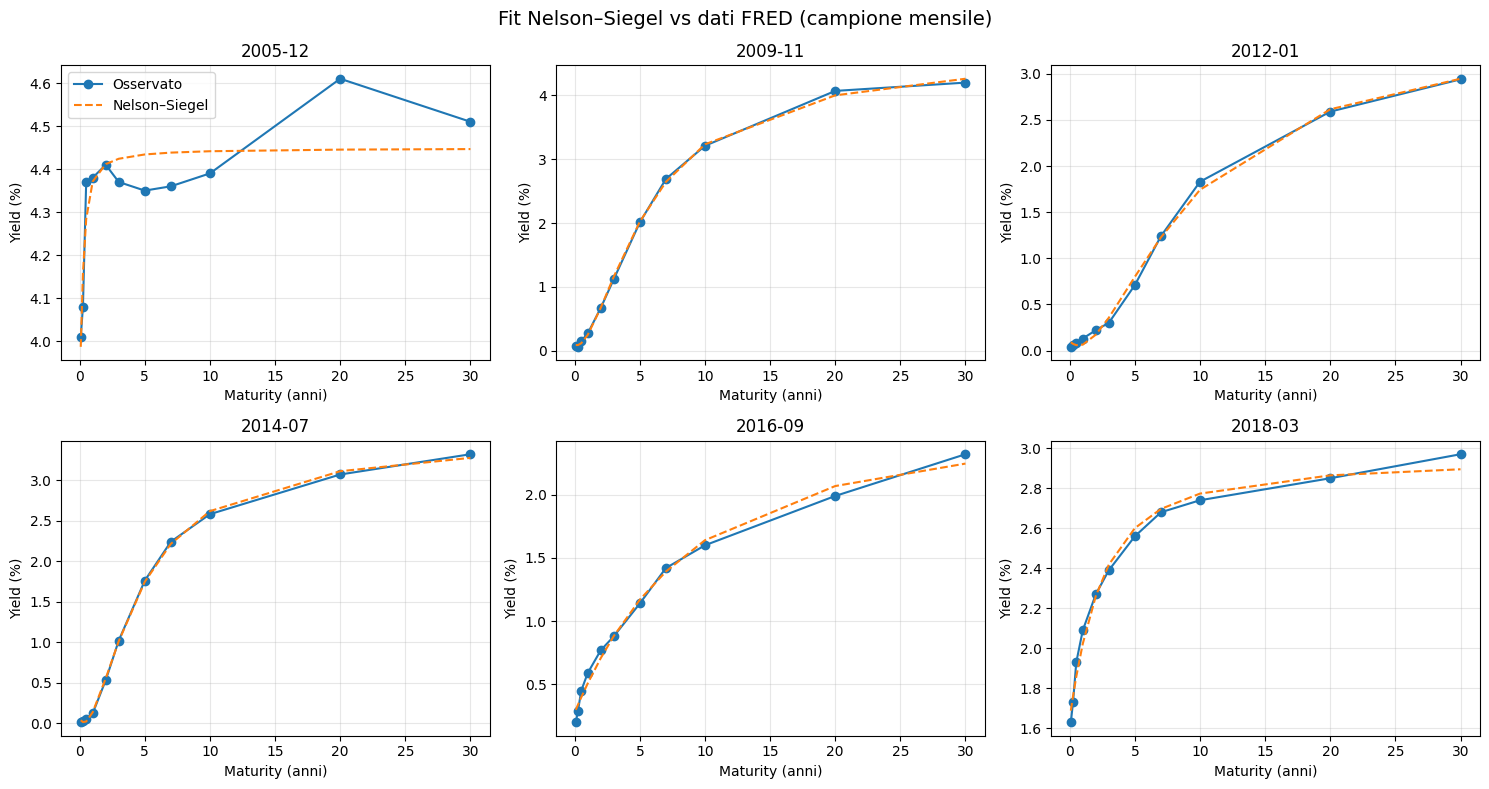

In [77]:
def plot_ns_fit_examples(yields_m, ns_hist, maturities, n_samples=6):
    """Confronta curve FRED vs NS fitted per alcune date casuali."""
    import random
    dates = random.sample(list(ns_hist.index), n_samples)
    dates = sorted(dates)

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, date in enumerate(dates):
        ax = axes[i]
        y_obs = yields_m.loc[date].values
        mask = ~np.isnan(y_obs)
        mats = np.array(maturities)[mask]
        y_obs = y_obs[mask]

        b = ns_hist.loc[date, ["beta0", "beta1", "beta2", "lambda"]].values
        y_fit = nelson_siegel(mats, *b)

        ax.plot(mats, y_obs, "o-", label="Osservato", color="tab:blue")
        ax.plot(mats, y_fit, "--", label="Nelson–Siegel", color="tab:orange")
        ax.set_title(date.strftime("%Y-%m"))
        ax.set_xlabel("Maturity (anni)")
        ax.set_ylabel("Yield (%)")
        ax.grid(alpha=0.3)
        if i == 0:
            ax.legend()
    plt.suptitle("Fit Nelson–Siegel vs dati FRED (campione mensile)", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_ns_fit_examples(yields_m, ns_hist, list(FRED_SERIES.values()))


In [78]:
owid = pd.read_csv(OWID_IPCC_FILE)

MACRO_VARS = [
    c for c in owid.columns 
    if c not in ["Scenario", "Year", "Region", "Country","annotation"] 
]

print("Scenari disponibili nel CSV:")
print(sorted(owid["Scenario"].unique()))

# scegliamo gli scenari "importanti" solo se esistono davvero
scenarios = ["SSP1 - 1.9", "SSP2 - 4.5", "SSP5 - 6.0"]


# range storico condiviso
hist_start_year = max(ns_hist.index.year.min(), int(owid["Year"].min()))
hist_end_year   = min(ns_hist.index.year.max(), int(owid["Year"].max()))

def build_macro_monthly(df, scenario, macro_vars, start_year, end_year):
    sub = df[df["Scenario"] == scenario].copy()
    if sub.empty:
        raise ValueError(f"Nessun dato per scenario {scenario} nel CSV.")

    # limitiamo solo agli anni necessari
    sub = sub[(sub["Year"] >= start_year) & (sub["Year"] <= end_year)]
    if sub.empty:
        raise ValueError(f"Nessun dato per {scenario} tra {start_year}-{end_year}.")

    idx = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-31", freq="M")
    out = pd.DataFrame(index=idx)

    years = sub["Year"].values.astype(float)
    for col in macro_vars:
        if col not in sub.columns:
            raise ValueError(f"Colonna {col} mancante nel CSV.")
        vals = sub[col].values.astype(float)
        out[col] = np.interp(
            np.linspace(start_year, end_year, len(idx)),
            years,
            vals
        )
    return out

# usiamo SSP2-4.5 (se c'è) come backbone per calibrazione macro storica
if "SSP2-4.5" in owid["Scenario"].unique():
    base_scen = "SSP2-4.5"
else:
    base_scen = scenarios[0]

macro_hist = build_macro_monthly(
    owid, base_scen, MACRO_VARS,
    hist_start_year, hist_end_year
)

ns_hist_sub = ns_hist[(ns_hist.index.year >= hist_start_year) &
                      (ns_hist.index.year <= hist_end_year)]

print("Shape ns_hist_sub, macro_hist:", ns_hist_sub.shape, macro_hist.shape)


Scenari disponibili nel CSV:
['SSP1 - 1.9', 'SSP1 - 2.6', 'SSP1 - 3.4', 'SSP1 - 4.5', 'SSP1 - Baseline', 'SSP2 - 1.9', 'SSP2 - 2.6', 'SSP2 - 3.4', 'SSP2 - 4.5', 'SSP2 - 6.0', 'SSP2 - Baseline', 'SSP3 - 3.4', 'SSP3 - 4.5', 'SSP3 - 6.0', 'SSP3 - Baseline', 'SSP4 - 2.6', 'SSP4 - 3.4', 'SSP4 - 4.5', 'SSP4 - 6.0', 'SSP4 - Baseline', 'SSP5 - 1.9', 'SSP5 - 2.6', 'SSP5 - 3.4', 'SSP5 - 4.5', 'SSP5 - 6.0', 'SSP5 - Baseline']
Shape ns_hist_sub, macro_hist: (251, 4) (252, 177)


/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_45746/1424225069.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-31", freq="M")
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_45746/1424225069.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[col] = np.interp(
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_45746/1424225069.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

In [79]:
# %% [markdown]
# SEZIONE 2 – PCA a blocchi sullo storico

# %%
def build_block_pca(df_hist, blocks, n_components_dict):
    """
    Costruisce PCA per ciascun blocco di variabili.
    Output:
    - pca_features_hist: DataFrame con le componenti PCA storiche
    - block_scalers: dict {block_name: StandardScaler}
    - block_pcas: dict {block_name: PCA}
    """
    block_scalers = {}
    block_pcas = {}
    block_components_hist = []

    for block_name, cols in blocks.items():
        cols_existing = [c for c in cols if c in df_hist.columns]
        if not cols_existing:
            print(f"[WARN] Blocco '{block_name}' senza colonne presenti, saltato.")
            continue

        X_block = df_hist[cols_existing].values

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_block)

        n_comp = n_components_dict[block_name]
        pca = PCA(n_components=n_comp)
        Z_block = pca.fit_transform(X_scaled)

        block_scalers[block_name] = scaler
        block_pcas[block_name] = pca

        col_names = [f"{block_name}_PC{i+1}" for i in range(n_comp)]
        block_components_hist.append(
            pd.DataFrame(Z_block, index=df_hist.index, columns=col_names)
        )

    if not block_components_hist:
        raise ValueError("Nessun blocco PCA costruito: controllare BLOCKS/df_hist.")

    pca_features_hist = pd.concat(block_components_hist, axis=1)
    return pca_features_hist, block_scalers, block_pcas

# Allineamento storico: fattori + macro/clima
df_hist = ns_hist_sub.join(macro_hist, how="inner")

pca_features_hist, block_scalers, block_pcas = build_block_pca(
    df_hist=df_hist,
    blocks=BLOCKS,
    n_components_dict=N_COMPONENTS
)

pca_features_hist.head()


,macro_PC1,climate_physical_PC1,climate_physical_PC2,transition_PC1,transition_PC2,energy_use_PC1,energy_use_PC2
2005-01-31,-3.466060,-4.715503,-1.691896,-3.676341,-2.969970,-0.875389,-4.326884
2005-02-28,-3.441300,-4.663218,-1.646559,-3.666392,-2.899443,-0.817173,-4.244343
2005-03-31,-3.416539,-4.610932,-1.601221,-3.656442,-2.828915,-0.758957,-4.161802
2005-04-30,-3.391779,-4.558647,-1.555883,-3.646492,-2.758388,-0.700741,-4.079262
2005-05-31,-3.367018,-4.506361,-1.510546,-3.636542,-2.687860,-0.642525,-3.996721


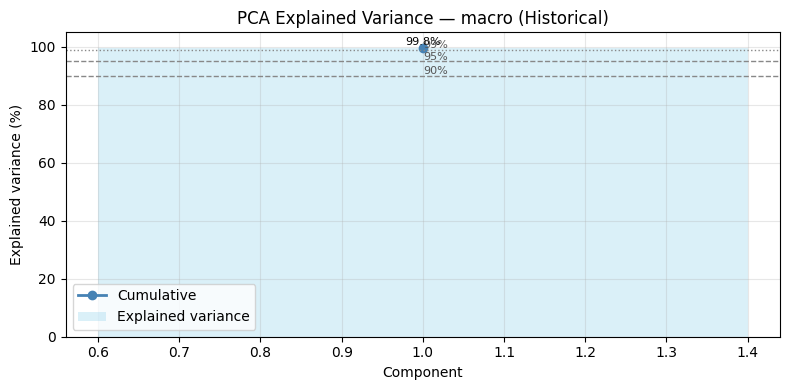

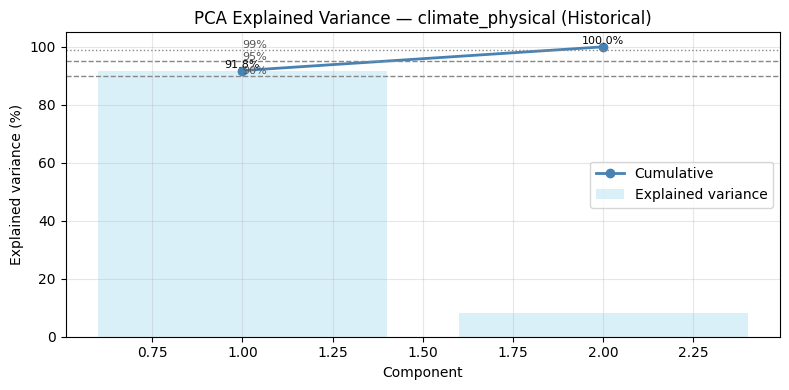

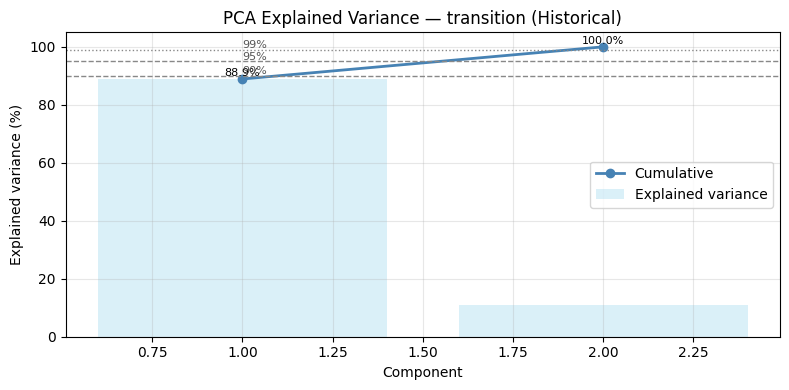

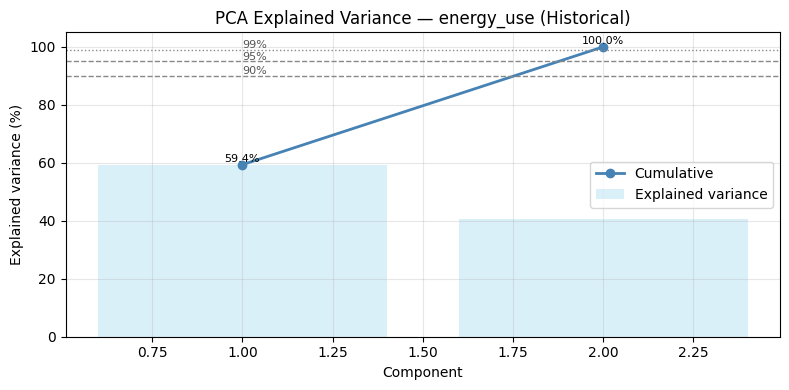

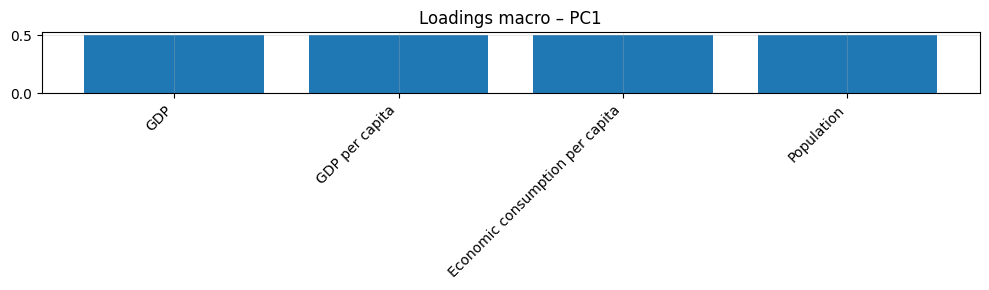

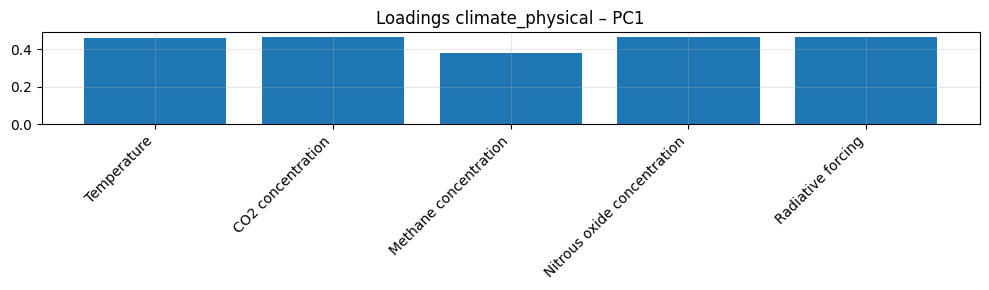

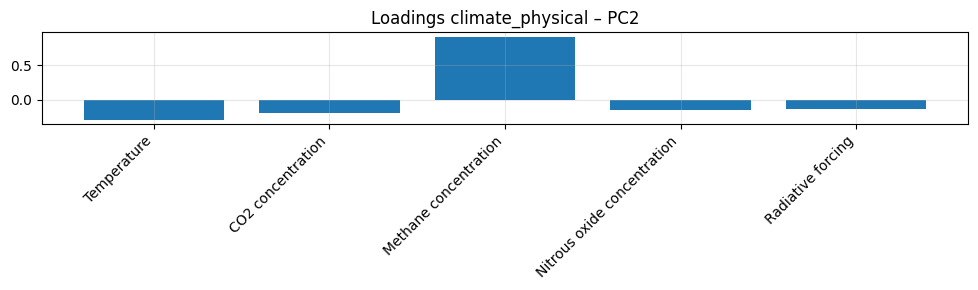

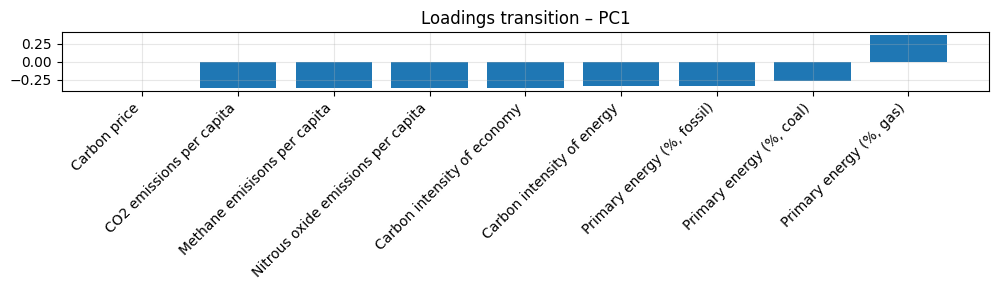

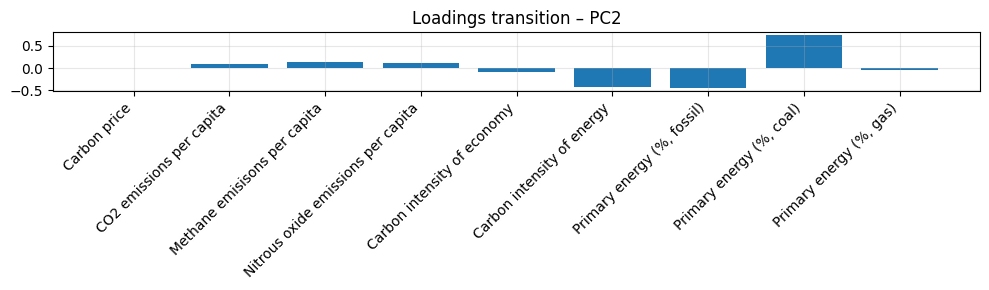

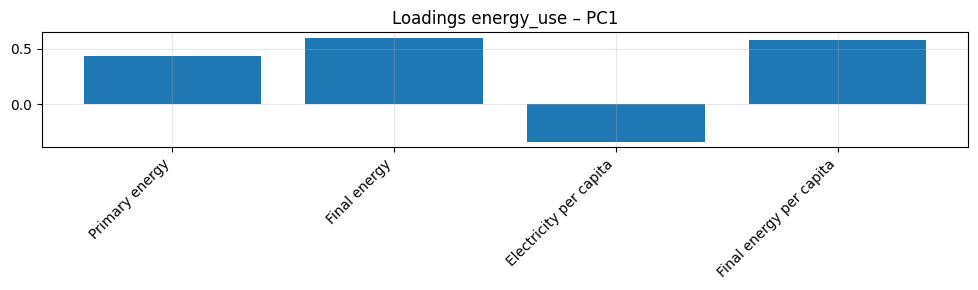

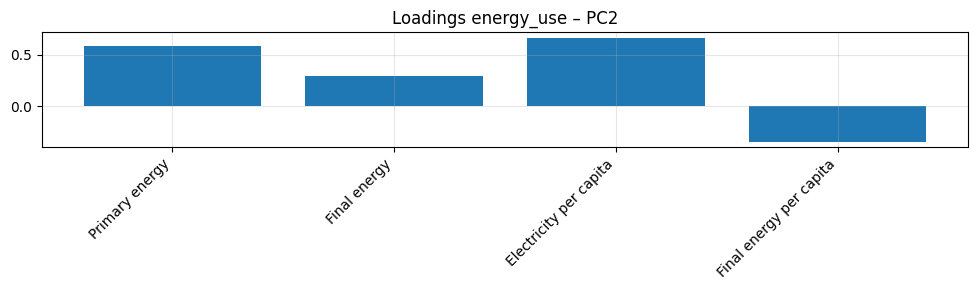

In [80]:
# %% [markdown]
# SEZIONE 3 – Diagnostica PCA (scree plot + loadings + biplot)

# %%
def plot_scree_advanced(block_pcas, BLOCKS, title_suffix="Historical"):
    for block_name in BLOCKS.keys():
        if block_name not in block_pcas:
            continue
        pca = block_pcas[block_name]
        ev = pca.explained_variance_ratio_
        cum_ev = ev.cumsum()
        xs = np.arange(1, len(ev)+1)

        plt.figure(figsize=(8,4))
        plt.bar(xs, ev*100, alpha=0.3, color="skyblue", label="Explained variance")
        plt.plot(xs, cum_ev*100, marker="o", color="steelblue",
                 linewidth=2, label="Cumulative")
        for i, v in enumerate(cum_ev):
            plt.text(xs[i], v*100+1, f"{v*100:.1f}%", ha="center", fontsize=8)

        for thr, style in [(90, "--"), (95, "--"), (99, ":")]:
            plt.axhline(thr, color="#888", linestyle=style, linewidth=1)
            plt.text(1, thr+0.5, f"{thr}%", color="#555", fontsize=8)

        plt.title(f"PCA Explained Variance — {block_name} ({title_suffix})")
        plt.xlabel("Component")
        plt.ylabel("Explained variance (%)")
        plt.ylim(0, 105)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_pca_loadings(block_pcas, BLOCKS):
    for block_name, cols in BLOCKS.items():
        if block_name not in block_pcas:
            continue
        pca = block_pcas[block_name]
        loadings = pd.DataFrame(
            pca.components_,
            columns=cols,
            index=[f"PC{i+1}" for i in range(pca.n_components_)]
        )
        for i in range(pca.n_components_):
            plt.figure(figsize=(10,3))
            plt.bar(loadings.columns, loadings.iloc[i].values)
            plt.xticks(rotation=45, ha="right")
            plt.title(f"Loadings {block_name} – PC{i+1}")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

plot_scree_advanced(block_pcas, BLOCKS, title_suffix="Historical")
plot_pca_loadings(block_pcas, BLOCKS)


In [103]:
# %% [markdown]
# SEZIONE 4 – Stima DNS dinamico AR(2) con ΔPCA

# %%
def fit_dns_pca_deltas_AR2_stable(ns_hist_sub, pca_features_hist, targets,
                                  rho_max=0.90, alphas=None):
    """
    Modello:
        beta_t = a + phi1 * beta_{t-1} + phi2 * beta_{t-2} + delta' * dZ_t + eps_t

    Con aggiunta:
    - vincolo di stabilità/mean-reversion: phi1 + phi2 <= rho_max
    - ricalcolo dell'intercetta a per preservare il livello medio storico

    ns_hist_sub: DataFrame con colonne TARGETS (beta0, beta1, beta2) indicizzate nel tempo
    pca_features_hist: DataFrame con PCA storiche (livelli) indicizzate nello stesso modo
    """

    # merge storico
    data = ns_hist_sub.join(pca_features_hist, how="inner")
    pca_vars = list(pca_features_hist.columns)

    # Δ delle PCA
    for col in pca_vars:
        data[f"d_{col}"] = data[col].diff()

    # lag AR(1) e AR(2)
    for t in targets:
        data[f"{t}_lag1"] = data[t].shift(1)
        data[f"{t}_lag2"] = data[t].shift(2)

    data = data.dropna()

    pca_delta_vars = [f"d_{col}" for col in pca_vars]

    if alphas is None:
        alphas = np.logspace(-4, 4, 21)

    params = {
        "a": {},
        "phi1": {},
        "phi2": {},
        "delta": {},
        "sigma_resid": {},
        "pca_vars": pca_delta_vars,
    }
    models = {}

    Z = data[pca_delta_vars].values
    z_mean = Z.mean(axis=0)

    for t in targets:
        y = data[t].values
        mu_y = y.mean()

        X_lag1 = data[f"{t}_lag1"].values.reshape(-1, 1)
        X_lag2 = data[f"{t}_lag2"].values.reshape(-1, 1)
        X = np.hstack([X_lag1, X_lag2, Z])

        model = RidgeCV(alphas=alphas, cv=5)
        model.fit(X, y)

        # coefficienti grezzi
        a_raw = float(model.intercept_)
        phi1_raw = float(model.coef_[0])
        phi2_raw = float(model.coef_[1])
        delta_raw = model.coef_[2:].copy()

        # imponiamo stabilità: phi1 + phi2 <= rho_max
        sum_phi = phi1_raw + phi2_raw
        if sum_phi > rho_max:
            scale = rho_max / sum_phi
            phi1 = phi1_raw * scale
            phi2 = phi2_raw * scale
        else:
            phi1 = phi1_raw
            phi2 = phi2_raw

        # ricalcolo di a per preservare il livello medio storico:
        # mu_y ≈ a + (phi1+phi2)*mu_y + delta' * E[dZ]  --> E[dZ] ~ 0, ma lo lasciamo generale
        a_new = mu_y * (1.0 - phi1 - phi2) - float(np.dot(delta_raw, z_mean))

        # ricalcolo dei residui con i parametri "stabili"
        y_hat = (
            a_new
            + phi1 * X_lag1.ravel()
            + phi2 * X_lag2.ravel()
            + Z @ delta_raw
        )
        resid = y - y_hat
        sigma_resid = resid.std()

        # salvataggio
        params["a"][t] = a_new
        params["phi1"][t] = phi1
        params["phi2"][t] = phi2
        params["delta"][t] = delta_raw
        params["sigma_resid"][t] = sigma_resid

        models[t] = model

        print(
            f"{t}: phi1_raw={phi1_raw:.3f}, phi2_raw={phi2_raw:.3f}, "
            f"phi1={phi1:.3f}, phi2={phi2:.3f}, "
            f"sigma={sigma_resid:.4f}, alpha_ridge={model.alpha_:.4f}"
        )

    return params, models


params, models = fit_dns_pca_deltas_AR2_stable(
    ns_hist_sub=ns_hist_sub,
    pca_features_hist=pca_features_hist,
    targets=TARGETS,
    rho_max=0.90,          # puoi provare 0.85, 0.9, 0.95
)


beta0: phi1_raw=0.904, phi2_raw=0.049, phi1=0.854, phi2=0.046, sigma=0.2514, alpha_ridge=0.3981
beta1: phi1_raw=0.424, phi2_raw=0.461, phi1=0.424, phi2=0.461, sigma=1.0181, alpha_ridge=6.3096
beta2: phi1_raw=0.554, phi2_raw=0.312, phi1=0.554, phi2=0.312, sigma=1.4049, alpha_ridge=15.8489


Diagnostica AR(2) – beta0
phi1 = 0.8540, phi2 = 0.0460
sigma(resid) = 0.2514
Jarque-Bera: stat=42.924, p-value=0.000


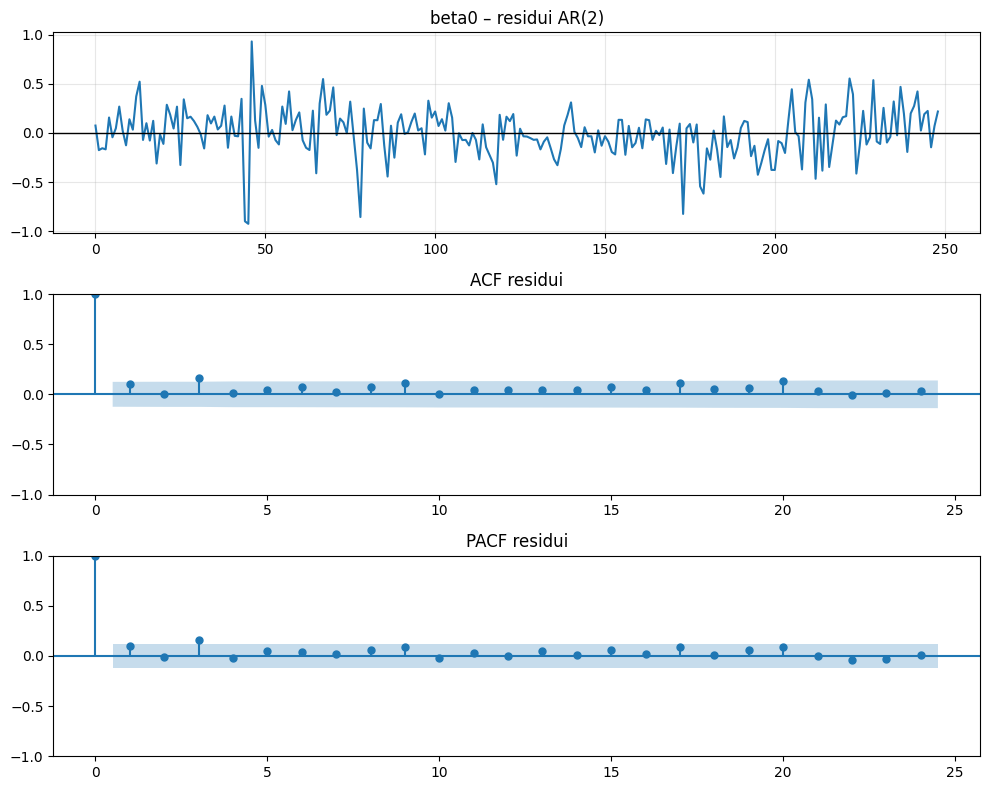

Diagnostica AR(2) – beta1
phi1 = 0.4241, phi2 = 0.4612
sigma(resid) = 1.0181
Jarque-Bera: stat=23726.277, p-value=0.000


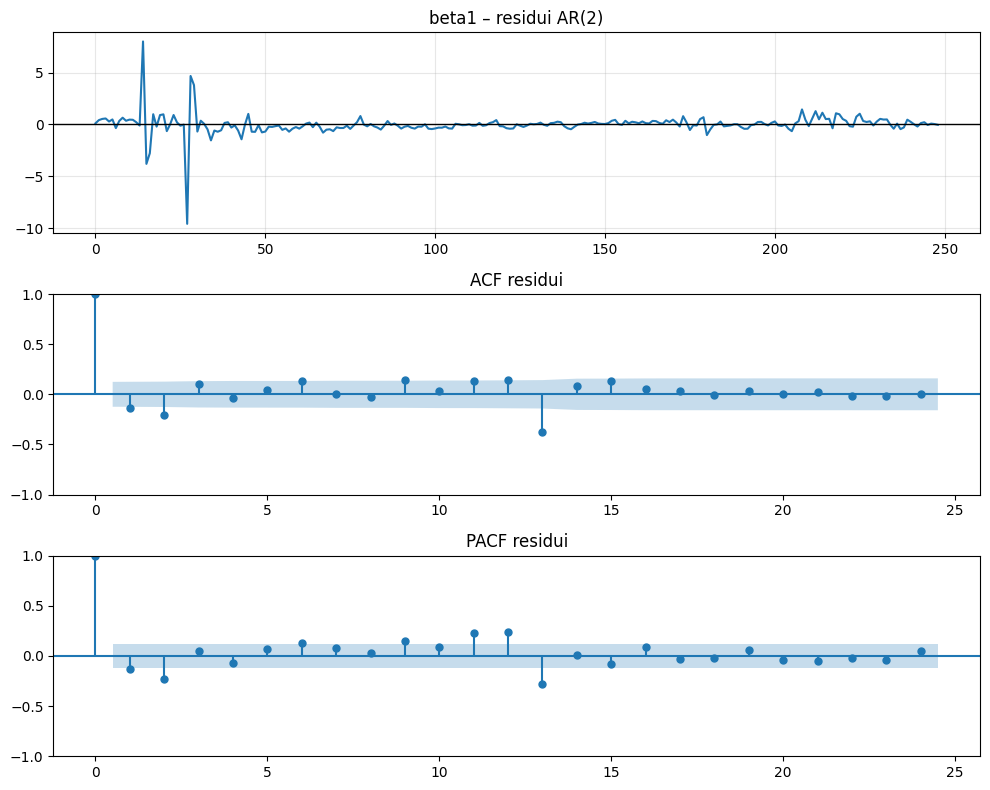

Diagnostica AR(2) – beta2
phi1 = 0.5536, phi2 = 0.3118
sigma(resid) = 1.4049
Jarque-Bera: stat=2424.562, p-value=0.000


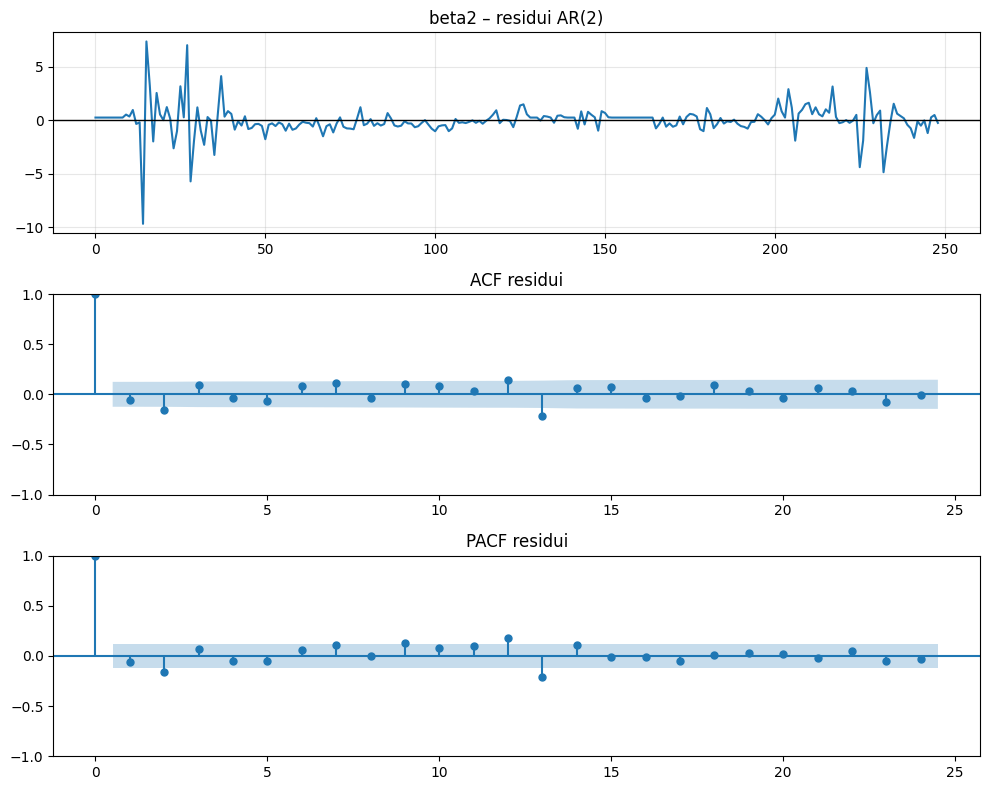

In [104]:
# %% [markdown]
# SEZIONE 5 – Diagnostica AR(2) per i fattori β

# %%
def diagnose_ar2(ns_hist_sub, pca_features_hist, params, target):
    """
    Residui del modello:
        beta_t = a + phi1 * beta_{t-1} + phi2 * beta_{t-2} + ...
    """
    data = ns_hist_sub.join(pca_features_hist, how="inner")
    pca_vars = list(pca_features_hist.columns)

    # ricostruzione ΔPCA e lag
    for col in pca_vars:
        data[f"d_{col}"] = data[col].diff()
    data[f"{target}_lag1"] = data[target].shift(1)
    data[f"{target}_lag2"] = data[target].shift(2)

    data = data.dropna()
    pca_delta_vars = [f"d_{col}" for col in pca_vars]

    y = data[target].values
    X_lag1 = data[f"{target}_lag1"].values.reshape(-1, 1)
    X_lag2 = data[f"{target}_lag2"].values.reshape(-1, 1)
    X_pca = data[pca_delta_vars].values
    X = np.hstack([X_lag1, X_lag2, X_pca])

    a = params["a"][target]
    phi1 = params["phi1"][target]
    phi2 = params["phi2"][target]
    delta = params["delta"][target]

    y_hat = a + phi1 * X_lag1.ravel() + phi2 * X_lag2.ravel() + np.dot(X_pca, delta)
    resid = y - y_hat

    print("="*70)
    print(f"Diagnostica AR(2) – {target}")
    print("="*70)
    print(f"phi1 = {phi1:.4f}, phi2 = {phi2:.4f}")
    print(f"sigma(resid) = {resid.std():.4f}")

    jb = jarque_bera(resid)
    print(f"Jarque-Bera: stat={jb[0]:.3f}, p-value={jb[1]:.3f}")

    fig, ax = plt.subplots(3, 1, figsize=(10, 8))
    ax[0].plot(resid)
    ax[0].axhline(0, color="black", lw=1)
    ax[0].set_title(f"{target} – residui AR(2)")
    ax[0].grid(alpha=0.3)

    plot_acf(resid, ax=ax[1])
    ax[1].set_title("ACF residui")

    plot_pacf(resid, ax=ax[2])
    ax[2].set_title("PACF residui")

    plt.tight_layout()
    plt.show()

for t in TARGETS:
    diagnose_ar2(ns_hist_sub, pca_features_hist, params, t)


In [122]:
# %% [markdown]
# SEZIONE 6 – Preprocessing scenari climatici

# %%
scen_raw = owid.copy()

scenario_col_candidates = [c for c in scen_raw.columns if c.lower() == "scenario"]
if not scenario_col_candidates:
    raise ValueError("Nessuna colonna 'Scenario' trovata.")
SCENARIO_COL = scenario_col_candidates[0]

year_col_candidates = [c for c in scen_raw.columns if c.lower() == "year"]
if not year_col_candidates:
    raise ValueError("Nessuna colonna 'Year' trovata.")
YEAR_COL = year_col_candidates[0]

print("Scenario col:", SCENARIO_COL, "Year col:", YEAR_COL)
print("Scenari disponibili:", scen_raw[SCENARIO_COL].unique())

scenario_name = "SSP5 - 6.0"  # adatta al nome reale
df_scn = scen_raw[scen_raw[SCENARIO_COL] == scenario_name].copy()

if "Region" in df_scn.columns and "World" in df_scn["Region"].unique():
    df_scn = df_scn[df_scn["Region"] == "World"].copy()

# Solo colonne numeriche
df_scn = df_scn.set_index(YEAR_COL)
numeric_cols = df_scn.select_dtypes(include=[np.number]).columns
df_scn = df_scn[numeric_cols]

# Media per anno (se più righe per anno)
df_scn = df_scn.groupby(level=0).mean().sort_index()

# Seleziona solo le colonne richieste nei BLOCKS
macro_cols_needed = sorted({c for cols in BLOCKS.values() for c in cols})
macro_cols_existing = [c for c in macro_cols_needed if c in df_scn.columns]
df_scn = df_scn[macro_cols_existing]

# Gestione NaN
nan_frac = df_scn.isna().mean()
cols_keep = nan_frac[nan_frac <= 0.5].index
df_scn = df_scn[cols_keep]
df_scn = df_scn.interpolate(method="index").ffill().bfill()

df_scn.head()


Scenario col: Scenario Year col: Year
Scenari disponibili: ['SSP1 - 1.9' 'SSP1 - 2.6' 'SSP1 - 3.4' 'SSP1 - 4.5' 'SSP1 - Baseline'
 'SSP2 - 1.9' 'SSP2 - 2.6' 'SSP2 - 3.4' 'SSP2 - 4.5' 'SSP2 - 6.0'
 'SSP2 - Baseline' 'SSP3 - 3.4' 'SSP3 - 4.5' 'SSP3 - 6.0'
 'SSP3 - Baseline' 'SSP4 - 2.6' 'SSP4 - 3.4' 'SSP4 - 4.5' 'SSP4 - 6.0'
 'SSP4 - Baseline' 'SSP5 - 1.9' 'SSP5 - 2.6' 'SSP5 - 3.4' 'SSP5 - 4.5'
 'SSP5 - 6.0' 'SSP5 - Baseline']


,CO2 concentration,CO2 emissions per capita,Carbon intensity of economy,Carbon intensity of energy,Carbon price,Economic consumption per capita,Electricity per capita,Final energy,Final energy per capita,GDP,...,Methane emisisons per capita,Nitrous oxide concentration,Nitrous oxide emissions per capita,Population,Primary energy,"Primary energy (%, coal)","Primary energy (%, fossil)","Primary energy (%, gas)",Radiative forcing,Temperature
Year,,,,,,,,,,,,,,,,,,,,,
2005,379.85000,5.415825,0.621449,0.272983,0.000,4562.644120,2284.569254,91861.1846,14121.627148,5.669000e+13,...,0.051275,319.85500,0.001508,6.505000e+09,129055.6588,26.302195,83.383556,21.110633,1.870916,0.913386
2010,390.50530,5.270526,0.537739,0.260207,0.000,4779.518422,2537.232472,99000.0792,14360.324804,6.757000e+13,...,0.053881,323.68957,0.001494,6.894000e+09,139639.0006,26.934553,83.369803,22.319475,2.138942,0.989292
2020,414.85415,5.238395,0.388227,0.229779,7.333,6238.011838,3226.888763,125222.3224,16581.345657,1.019000e+14,...,0.051776,331.11989,0.001425,7.552000e+09,172166.8044,19.102936,84.591804,27.347531,2.676709,1.259277
2030,443.95630,5.939408,0.289214,0.228183,11.720,8770.578880,4390.506506,156166.7916,19389.966675,1.654000e+14,...,0.051526,338.41985,0.001378,8.054000e+09,209639.0566,13.952564,88.339738,32.184974,3.191565,1.554898
2040,479.79912,6.487295,0.211044,0.223489,22.270,12792.261799,5659.358991,184666.8144,21976.295894,2.583000e+14,...,0.050342,345.45721,0.001350,8.403000e+09,243916.8618,13.164788,90.433891,37.285047,3.720313,1.885800


In [123]:
# %% [markdown]
# SEZIONE 7 – PCA sugli scenari e Δ delle PCA

# %%
def transform_scenarios_with_pca(df_scn, blocks, n_components_dict, block_scalers, block_pcas):
    block_components_scn = []

    for block_name, cols in blocks.items():
        if block_name not in block_scalers:
            continue
        cols_existing = [c for c in cols if c in df_scn.columns]
        if not cols_existing:
            continue

        X_block = df_scn[cols_existing].values
        scaler = block_scalers[block_name]
        pca = block_pcas[block_name]

        X_scaled = scaler.transform(X_block)
        Z_block = pca.transform(X_scaled)

        n_comp = n_components_dict[block_name]
        col_names = [f"{block_name}_PC{i+1}" for i in range(n_comp)]
        block_components_scn.append(
            pd.DataFrame(Z_block, index=df_scn.index, columns=col_names)
        )

    if not block_components_scn:
        raise ValueError("Nessun blocco PCA applicabile allo scenario.")

    pca_features_scn = pd.concat(block_components_scn, axis=1)
    return pca_features_scn

pca_features_scn = transform_scenarios_with_pca(
    df_scn=df_scn,
    blocks=BLOCKS,
    n_components_dict=N_COMPONENTS,
    block_scalers=block_scalers,
    block_pcas=block_pcas
)

# ΔPCA per scenario
pca_vars_scn = list(pca_features_scn.columns)
pca_features_scn_d = pca_features_scn.copy()
for col in pca_vars_scn:
    pca_features_scn_d[f"d_{col}"] = pca_features_scn_d[col].diff()

pca_delta_vars = [f"d_{col}" for col in pca_vars_scn]
pca_features_scn_d = pca_features_scn_d[pca_delta_vars].dropna()
pca_features_scn_d = (pca_features_scn_d - np.mean(pca_features_scn_d, axis=0))/np.std(pca_features_scn_d, axis=0)


pca_features_scn_d.head()


,d_macro_PC1,d_climate_physical_PC1,d_climate_physical_PC2,d_transition_PC1,d_transition_PC2,d_energy_use_PC1,d_energy_use_PC2
Year,,,,,,,
2010,-1.728532,0.125679,1.204982,-0.737624,-0.250884,-0.693723,-2.478290
2020,-1.210275,1.302715,1.370014,0.757288,-1.279281,0.947672,-0.183124
2030,-0.752114,1.156439,1.048378,-1.444923,-1.911457,1.172865,0.865078
2040,-0.260917,1.146231,0.799246,-1.269980,-0.987775,0.876908,0.774963
2050,-0.079299,0.721590,0.274485,-0.695976,0.390504,1.012329,1.354712


In [124]:
# %% [markdown]
# SEZIONE 8 – Simulazione dei fattori β sullo scenario (AR(2))

# %%
def simulate_betas_AR2(ns_hist_sub, pca_features_scn, targets, params,
                       stochastic=False, random_state=None,
                       z_clip=3.0, beta_clip=(-5, 10)):
    """
    Simula:
        β_t = a + φ1 β_{t-1} + φ2 β_{t-2} + δ' z_t  + ε_t

    Migliorie:
    - clipping degli shock PCA (z_clip)
    - clipping del livello dei beta per evitare drift (beta_clip)
    - inizializzazione robusta con ultimi due valori storici
    - simulazione deterministica o stocastica
    """

    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random.default_rng()

    # solo le colonne PCA delta richieste dal modello
    pca_vars = params["pca_vars"]
    Z = pca_features_scn[pca_vars].copy()

    # clipping sugli shock PCA
    

    # inizializzazione beta_{T-1}, beta_{T-2}
    last = ns_hist_sub.iloc[-1]
    prev = ns_hist_sub.iloc[-2]

    betas_t1 = {t: float(last[t]) for t in targets}   # β_{T-1}
    betas_t2 = {t: float(prev[t]) for t in targets}   # β_{T-2}

    out = {t: [] for t in targets}

    for idx, row in Z.iterrows():
        z_t = row.values

        new_betas = {}

        for t in targets:
            a = params["a"][t]
            phi1 = params["phi1"][t]
            phi2 = params["phi2"][t]
            delta = params["delta"][t]
            sigma = params["sigma_resid"][t]

            # modello AR(2)
            mean_t = a + phi1 * betas_t1[t] + phi2 * betas_t2[t] + np.dot(delta, z_t)

            # shock stocastico
            eps = rng.normal(scale=sigma) if stochastic else 0.0

            b_next = mean_t + eps

            # clipping su beta

            new_betas[t] = b_next
            out[t].append(b_next)

        # shift temporale
        betas_t2 = betas_t1
        betas_t1 = new_betas

    return pd.DataFrame(out, index=Z.index)



betas_scn_df = simulate_betas_AR2(
    ns_hist_sub=ns_hist_sub,
    pca_features_scn=pca_features_scn_d,   # <-- qui cambia
    targets=TARGETS,
    params=params,
    stochastic=False,
    random_state=42,
    z_clip=2.0,          # opzionale
    beta_clip=(-12,12)   # opzionale
)


betas_scn_df.head()


,beta0,beta1,beta2
Year,,,
2010,5.167435,-0.922111,-2.990134
2020,5.093595,-1.182158,-2.948780
2030,5.650292,-1.122278,-2.775359
2040,6.009359,-1.273360,-2.686364
2050,6.455073,-1.393770,-2.605785


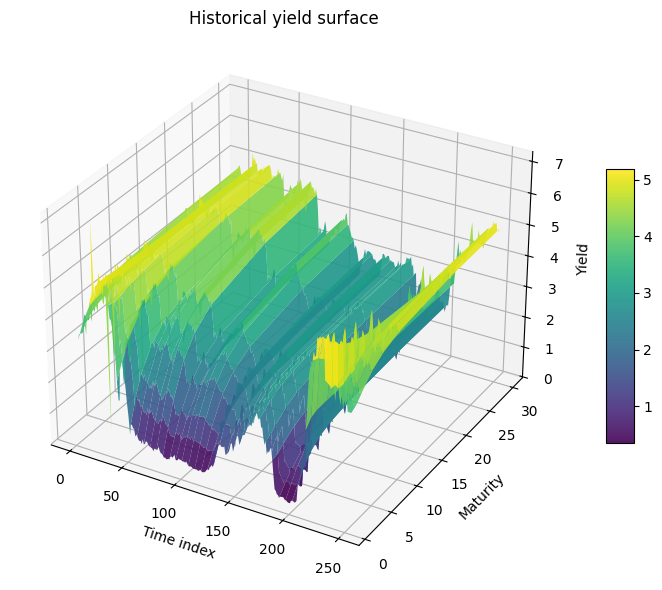

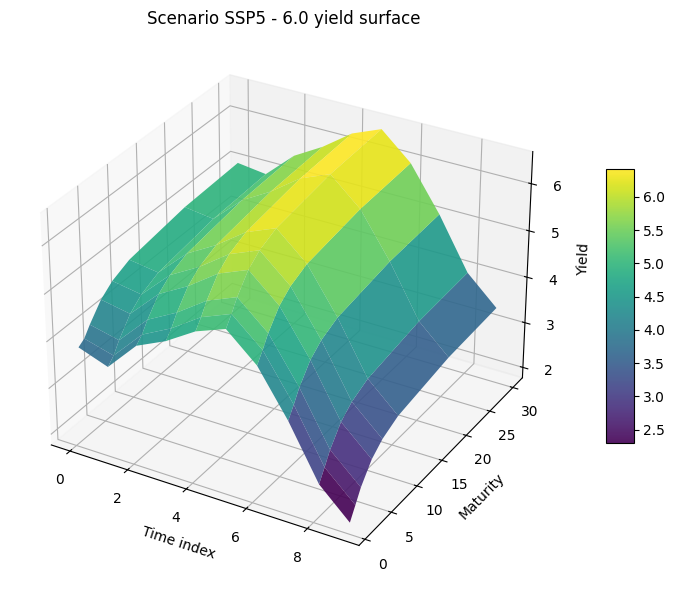

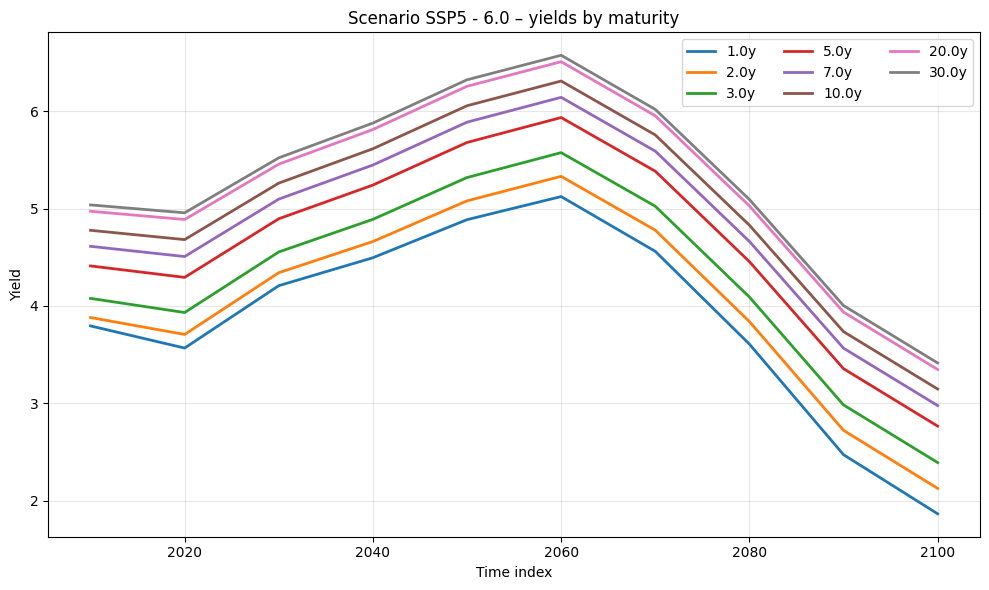

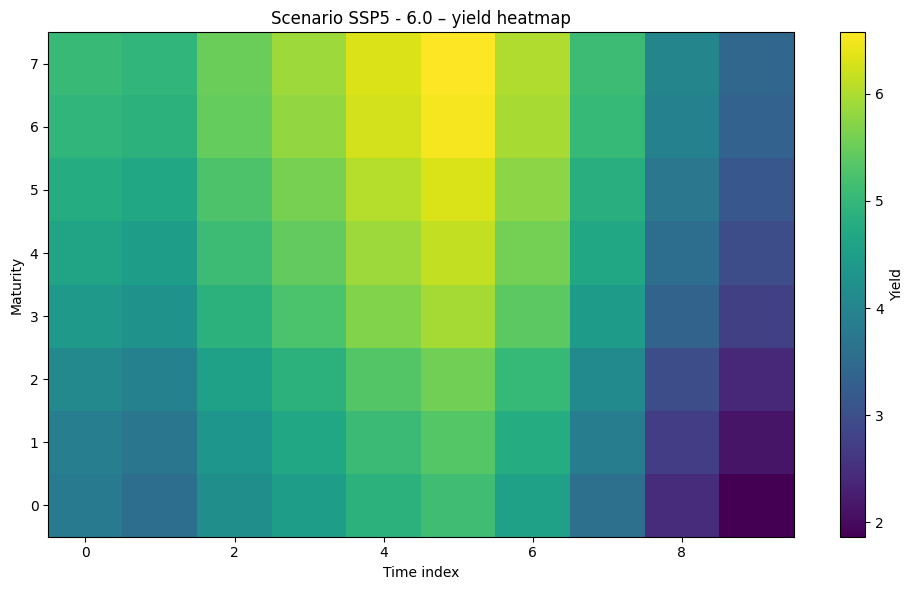

In [125]:
# %% [markdown]
# SEZIONE 9 – Costruzione della curva NS e grafici

# %%
def nelson_siegel_yield(maturities, beta0, beta1, beta2, tau=1.0):
    maturities = np.asarray(maturities)
    lam = 1.0 / tau
    x = maturities * lam

    with np.errstate(divide='ignore', invalid='ignore'):
        factor1 = np.where(x == 0, 1.0, (1 - np.exp(-x)) / x)
        factor2 = factor1 - np.exp(-x)

    y = beta0 + beta1 * factor1 + beta2 * factor2
    return y

def make_yield_surface_from_betas(betas_df, maturities, tau=1.0):
    curves = []
    for date, row in betas_df.iterrows():
        b0, b1, b2 = row["beta0"], row["beta1"], row["beta2"]
        y = nelson_siegel_yield(maturities, b0, b1, b2, tau=tau)
        curves.append(pd.Series(y, index=maturities, name=date))
    surface = pd.DataFrame(curves)
    return surface

def plot_yield_surface(surface, title="Yield surface"):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")

    times = np.arange(len(surface.index))
    maturities = surface.columns.values.astype(float)
    T, M = np.meshgrid(times, maturities, indexing="ij")
    Z = surface.values

    surf = ax.plot_surface(T, M, Z,
                           cmap=cm.viridis,
                           linewidth=0,
                           antialiased=True,
                           alpha=0.9)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_xlabel("Time index")
    ax.set_ylabel("Maturity")
    ax.set_zlabel("Yield")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_yield_lines_by_maturity(surface, title="Yield by maturity"):
    plt.figure(figsize=(10,6))
    for m in surface.columns:
        plt.plot(surface.index, surface[m], label=f"{m}y", linewidth=2)
    plt.xlabel("Time index")
    plt.ylabel("Yield")
    plt.title(title)
    plt.legend(ncol=3)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_yield_heatmap(surface, title="Yield heatmap"):
    plt.figure(figsize=(10,6))
    plt.imshow(surface.T, aspect="auto", origin="lower",
               cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Yield")
    plt.xlabel("Time index")
    plt.ylabel("Maturity")
    plt.title(title)
    plt.tight_layout()
    plt.show()

maturities = MATURITIES
tau = 1.0

yield_surface_scn = make_yield_surface_from_betas(betas_scn_df, maturities, tau=tau)
yield_surface_hist = make_yield_surface_from_betas(ns_hist_sub[TARGETS], maturities, tau=tau)

plot_yield_surface(yield_surface_hist, title="Historical yield surface")
plot_yield_surface(yield_surface_scn, title=f"Scenario {scenario_name} yield surface")

plot_yield_lines_by_maturity(yield_surface_scn, title=f"Scenario {scenario_name} – yields by maturity")
plot_yield_heatmap(yield_surface_scn, title=f"Scenario {scenario_name} – yield heatmap")
